In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

In [9]:
# ✅ Ruta local a tus archivos Parquet
data_path = r'D:\Jhonatan\Nueva carpeta\CIC-IDS-20177-PAQUET'
all_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.parquet')]


In [10]:
# ✅ Cargar los archivos Parquet en un único DataFrame
df = pd.concat((pd.read_parquet(f) for f in all_files), ignore_index=True)


In [11]:
# ✅ Preprocesamiento
df.drop_duplicates(inplace=True)
df['Label'] = np.where(df['Label'] == 'Benign', 0, 1)

In [12]:
# ✅ División X e y
X = df.drop('Label', axis=1)
y = df['Label']

C:\Users\user\AppData\Local\Temp\ipykernel_4844\4268523673.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Set1')


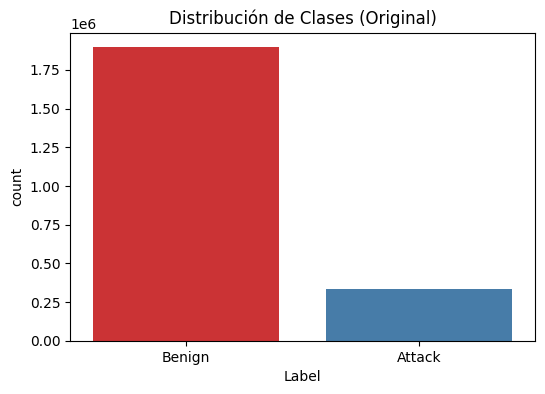

In [13]:
# ✅ Visualización de clases
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='Set1')
plt.title('Distribución de Clases (Original)')
plt.xticks([0, 1], ['Benign', 'Attack'])
plt.show()

In [14]:
print(f"Class 0 (Benign): {(y == 0).mean() * 100:.2f}%")
print(f"Class 1 (Attack): {(y == 1).mean() * 100:.2f}%")

Class 0 (Benign): 84.92%
Class 1 (Attack): 15.08%


In [16]:
df_sampled = df.sample(frac=0.25, random_state=42)
X = df_sampled.drop('Label', axis=1).astype(np.float32)
y = df_sampled['Label']

# Balanceo
from imblearn.over_sampling import BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42, kind='borderline-1')
X_res, y_res = smote.fit_resample(X, y)


In [17]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_res, y_res)

C:\Users\user\AppData\Local\Temp\ipykernel_4844\2538526812.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_res, palette='Set1')


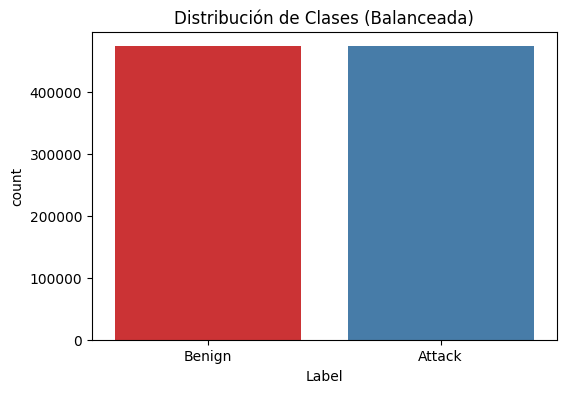

In [18]:
# ✅ Visualización después del balanceo
plt.figure(figsize=(6, 4))
sns.countplot(x=y_res, palette='Set1')
plt.title('Distribución de Clases (Balanceada)')
plt.xticks([0, 1], ['Benign', 'Attack'])
plt.show()

In [19]:
# ✅ División Train / Val / Test
X_train, X_temp, y_train, y_temp = train_test_split(X_res, y_res, test_size=0.3, stratify=y_res, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [20]:
# ✅ Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [21]:
# ✅ Tensores
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [23]:
# ✅ Dataset personalizado
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TabularDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
val_loader = DataLoader(TabularDataset(X_val_tensor, y_val_tensor), batch_size=128)
test_loader = DataLoader(TabularDataset(X_test_tensor, y_test_tensor), batch_size=128)


In [25]:
# ✅ Modelo TabTransformer
class TabTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, num_heads=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x.unsqueeze(1))
        x = x.mean(dim=1)
        return self.classifier(x)

In [26]:
# ✅ Inicialización
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TabTransformer(input_dim=X_train_tensor.shape[1], num_classes=2).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1., 5.], device=device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [27]:
# ✅ Entrenamiento
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
    accuracy = 100 * correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f} - Accuracy: {accuracy:.2f}%")

Epoch 1/10 - Loss: 411.1208 - Accuracy: 93.67%
Epoch 2/10 - Loss: 288.0286 - Accuracy: 95.87%
Epoch 3/10 - Loss: 237.6351 - Accuracy: 96.60%
Epoch 4/10 - Loss: 210.4552 - Accuracy: 96.92%
Epoch 5/10 - Loss: 196.4784 - Accuracy: 97.12%
Epoch 6/10 - Loss: 184.4798 - Accuracy: 97.40%
Epoch 7/10 - Loss: 174.4730 - Accuracy: 97.57%
Epoch 8/10 - Loss: 166.1603 - Accuracy: 97.75%
Epoch 9/10 - Loss: 157.5778 - Accuracy: 97.89%
Epoch 10/10 - Loss: 151.0619 - Accuracy: 98.06%


In [28]:
# ✅ Evaluación
model.eval()
preds, labels, probs = [], [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs_batch = torch.softmax(outputs, dim=1)[:, 1]
        preds_batch = torch.argmax(outputs, dim=1)
        preds.extend(preds_batch.cpu().numpy())
        probs.extend(probs_batch.cpu().numpy())
        labels.extend(y_batch.numpy())

print("Accuracy:", accuracy_score(labels, preds))
print("Precision:", precision_score(labels, preds))
print("Recall:", recall_score(labels, preds))
print("F1 Score:", f1_score(labels, preds))
print("MCC:", matthews_corrcoef(labels, preds))
print("AUC-ROC:", roc_auc_score(labels, probs))

Accuracy: 0.9820906021384356
Precision: 0.9665731713958935
Recall: 0.9987197523916713
F1 Score: 0.9823835487531483
MCC: 0.9647148944902745
AUC-ROC: 0.9977863117765964
